# A first look at the relationship between money demand and interest rates in the data
## Caio Machado
## Macroeconomics II

### This is a complement to lecture note #3.

In [1]:
### Preamble
using Plots, RCall, DataFrames, DataFramesMeta, GLM
gr(legend=false,linewidth=2)

# R packages used through RCall:
R"""
foo <- c("tidyverse","fredr")
pacman::p_load(char = foo)
fredr_set_key("59edcd766b87f7feca168face94a5ffe") # Fred data API Key
"""

# The next function downloads data from Fred using RCall and the fredr package. 
function fredfun(var_id,var_name;frequency=false, observation_start="1600-01-01",
        observation_end="3000-01-01", aggregation_method="avg")
        @rput var_id observation_start observation_end frequency frequency aggregation_method
        R"""
        if (frequency == FALSE) {
                df <- fredr(series_id=var_id, observation_start = as.Date(observation_start), 
                observation_end = as.Date(observation_end))
        } else {
                df <- fredr(series_id=var_id, observation_start = as.Date(observation_start), 
                observation_end = as.Date(observation_end), frequency=frequency, aggregation_method=aggregation_method)
        }
        """
        @rget df
        select!(df,[:date,:value])
        rename!(df,:value=>var_name)
        return df
end;

We will need data on:
* Real money supply;
* Real GDP;
* Short term interest rate.

We first download the nominal money supply (M2) and the nominal GDP, and then we compute it in real terms using the GDP deflator. For the short term interest rate, we use the "Effective Federal Funds Rate" in the US, which is roughly the rate at which banks borrow from each other overnight. This interest rate is a decent empirical counterpart for the interest rate of the model seen in class.

In [2]:
# Downloads GDP deflator:
deflator = fredfun("USAGDPDEFQISMEI","deflator",frequency="q",observation_start="1980-01-01",observation_end="2021-01-01")

# Downloads nominal GDP and M2:
gdp = fredfun("GDP","gdp",frequency="q",observation_start="1980-01-01",observation_end="2021-01-01")
m2 = fredfun("WM2NS","m2",frequency="q",aggregation_method="eop",observation_start="1980-01-01",observation_end="2021-01-01")
i = fredfun("DFF","i",frequency="q",aggregation_method="eop",observation_start="1980-01-01",observation_end="2021-01-01")

# Joining data:
df = innerjoin(deflator,gdp,m2,i,on=:date)

# Computing real variables:
df = @transform(df,real_gdp = :gdp ./ :deflator, real_m2 = :m2 ./ :deflator)

,date,deflator,gdp,m2,i,real_gdp,real_m2
,Date…,Float64,Float64,Float64?,Float64,Float64,Float64?
1,1980-10-01,41.8279,2985.56,missing,22.0,71.3771,missing
2,1981-01-01,42.9293,3124.21,1637.5,14.63,72.7757,38.1442
3,1981-04-01,43.7803,3162.53,1661.8,18.64,72.2364,37.9577
4,1981-07-01,44.6039,3260.61,1697.7,16.58,73.1014,38.0617
5,1981-10-01,45.3747,3280.82,1758.2,13.13,72.3049,38.7484
6,1982-01-01,45.9992,3274.3,1780.8,16.8,71.1817,38.7137
7,1982-04-01,46.5968,3331.97,1813.3,14.58,71.5064,38.9146
8,1982-07-01,47.2579,3366.32,1848.5,12.17,71.233,39.1152
9,1982-10-01,47.7476,3402.56,1921.4,11.2,71.2615,40.2408


Let's plot some variables first:

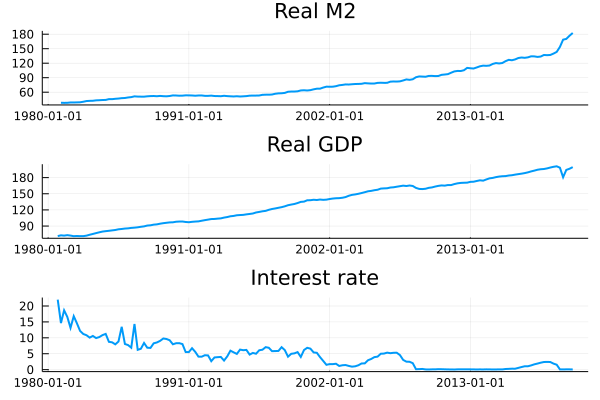

In [3]:
p1 = plot(df.date,df.real_m2,title="Real M2")
p2 = plot(df.date,df.real_gdp,title="Real GDP")
p3 = plot(df.date,df.i,title="Interest rate")
plot(p1,p2,p3,layout=(3,1))

The following relationship should hold according to the model seen in class:

$$ \log(M_t/P_t) = \text{Constant} + 0.5\log(y_t) - 0.5\log(i_t) + 0.5\log(z_t)$$

Or, taking the first difference:

$$ \Delta \log(M_t/P_t) =  0.5\Delta \log(y_t) - 0.5 \Delta \log(i_t) + 0.5 \Delta \log(z_t)$$

We do not observe $\Delta \log(z_t)$. But let's make the strong assumption that $\Delta \log(z_t)$ is constant (if $z_t$ changes we assume it changes at a constant rate). This is a strong assumption, but let's not take the econometrics so seriously here. We can then run a linear regression of $\Delta \log(M_t/P_t) $ on the log changes of the interest rate and real GDP and see what we get (the computer accepts anything).

In [4]:
logdif(x) = [missing;log.(x[2:end]) - log.(x[1:end-1])] # Function to compute first log differences
df = @transform(df,logdif_real_m2 = logdif(:real_m2), 
        logdif_real_gdp = logdif(:real_gdp),
        logdif_i= logdif(:i)) # Add log differences to dataframe

ols = lm(@formula(logdif_real_m2 ~ logdif_real_gdp + logdif_i), df)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}}}}, Matrix{Float64}}

logdif_real_m2 ~ 1 + logdif_real_gdp + logdif_i

Coefficients:
──────────────────────────────────────────────────────────────────────────────────
                      Coef.  Std. Error      t  Pr(>|t|)    Lower 95%    Upper 95%
──────────────────────────────────────────────────────────────────────────────────
(Intercept)       0.0122234  0.00120805  10.12    <1e-18   0.00983725   0.0146095
logdif_real_gdp  -0.450306   0.0921121   -4.89    <1e-05  -0.632245    -0.268367
logdif_i         -0.011653   0.00256762  -4.54    <1e-04  -0.0167246   -0.00658148
──────────────────────────────────────────────────────────────────────────────────

The coefficient of the log difference of real GDP is not 0.5 and has the "wrong" sign. The coefficient on the log changes of the interest rate have the right sign, but are far from -0.5. What could be going on here? Is this enough to "reject" the model seen in class?